In [3]:
from typing import Tuple, List
import cv2
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
from skimage import feature

In [62]:
class ShadowRemover:
    def __init__(self,
                 itr: int=1, method: str='rgb_lab_hsv',
                 lab_adjustment: bool=False,
                 ab_threshold: int=255,
                 region_adjustment_kernel_size: int=30, 
                 shadow_dilation_kernel_size: int=7, shadow_dilation_iteration: int=7,
                 shadow_size_threshold: int=7,
                 verbose: bool=True, plot_results: bool=True):
        
        self.itr = itr
        self.method = method
        self.lab_adjustment = lab_adjustment
        self.ab_threshold = ab_threshold
        self.region_adjustment_kernel_size = region_adjustment_kernel_size
        self.shadow_dilation_kernel_size = shadow_dilation_kernel_size
        self.shadow_dilation_iteration = shadow_dilation_iteration
        self.shadow_size_threshold = shadow_size_threshold
        self.verbose = verbose
        self.plot_results = plot_results


    def set_image(self,
                  image_path: str,
                  use_blurring: bool=False,
                  blur_kernel_size: Tuple[int,int]=(3,3)) -> None:
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        if use_blurring: image = cv2.GaussianBlur(image,blur_kernel_size,1)
        
        self.image = image

    
    def calculate_mask(self, 
                       itr_image) -> np.ndarray:
        
        img_shape = (itr_image.shape[0],itr_image.shape[1])
        rgb_image = itr_image
        lab_image = cv2.cvtColor(itr_image,cv2.COLOR_RGB2LAB)
        hsv_image = cv2.cvtColor(itr_image,cv2.COLOR_RGB2HSV)

        if self.method=='rgb_lab_hsv':

            img = []
            for i in range(img_shape[0]):
                img.append([])
                for j in range(img_shape[1]):
                    img[i].append([
                        rgb_image[i][j][0],rgb_image[i][j][1],rgb_image[i][j][2],
                        lab_image[i][j][0],lab_image[i][j][1],lab_image[i][j][2],
                        hsv_image[i][j][0],hsv_image[i][j][1],hsv_image[i][j][2]
                    ])
            img = np.array(img)

            pixel_values = img.reshape((-1,9))
            pixel_values = np.float32(pixel_values)

            return_val1, labels, centers = cv2.kmeans(data=pixel_values,
                                                    K=3, bestLabels=None,
                                                    criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,100,0.85),
                                                    attempts=10,
                                                    flags=cv2.KMEANS_RANDOM_CENTERS)
            
            centers = np.uint8(centers)[:,:3]
            segmented_image_flattened = centers[labels.flatten()]
            segmented_image = segmented_image_flattened.reshape(self.image.shape)

            th , reverse_mask = cv2.threshold(cv2.cvtColor(segmented_image,cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)
            mask = cv2.bitwise_not(reverse_mask)

            return mask
        
        elif self.method == 'mean_shift_binarization':
            
            pixel_values = rgb_image.reshape((-1,3))
            pixel_values = np.float32(pixel_values)

            criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS , 10 , 0.01)
            labels = cv2.pyrMeanShiftFiltering(rgb_image,35,25,termcrit=criteria)

            reverse_mask = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2GRAY)
            th , reverse_mask = cv2.threshold(reverse_mask, 0, 255, cv2.THRESH_OTSU)
            mask = cv2.bitwise_not(reverse_mask)

            return mask

        elif self.method == 'lab_thresholding':
            l_range = (0, 100)
            ab_range = (-128, 127)

            lab_image = lab_image.astype('int16')
            lab_image[:, :, 0] = lab_image[:, :, 0] * l_range[1] / 255
            lab_image[:, :, 1] += ab_range[0]
            lab_image[:, :, 2] += ab_range[0]

            # Calculate the mean values of L, A and B across all pixels
            means = [np.mean(lab_image[:, :, i]) for i in range(3)]
            thresholds = [means[i] - (np.std(lab_image[:, :, i]) / 3) for i in range(3)]

            # Apply threshold using only L
            if sum(means[1:]) <= self.ab_threshold:
                mask = cv2.inRange(lab_image, (l_range[0], ab_range[0], ab_range[0]),
                                        (thresholds[0], ab_range[1], ab_range[1]))
            else:  # Else, also consider B channel
                mask = cv2.inRange(lab_image, (l_range[0], ab_range[0], ab_range[0]),
                                        (thresholds[0], ab_range[1], thresholds[2]))

            kernel_size = (self.region_adjustment_kernel_size, self.region_adjustment_kernel_size)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
            cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, mask)
            cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, mask)

            return mask


    def median_filter(self,
                      img: np.ndarray, 
                      point: np.ndarray, 
                      filter_size: int) -> List:

        indices = [[x, y]
                for x in range(point[1] - filter_size // 2, point[1] + filter_size // 2 + 1) 
                for y in range(point[0] - filter_size // 2, point[0] + filter_size // 2 + 1)]
        indices = list(filter(lambda x: not (x[0] < 0 or x[1] < 0 or x[0] >= img.shape[0] or x[1] >= img.shape[1]), indices))

        pixel_values = [0, 0, 0]
        for channel in range(3): pixel_values[channel] = list(img[index[0], index[1], channel] for index in indices)
        pixel_values = list(np.median(pixel_values, axis=1))

        return pixel_values
    

    def edge_median_filter(self,
                           image: np.ndarray, 
                           contours_list: tuple, 
                           filter_size: int = 7) -> np.ndarray:
        
        temp_img = image.copy()
        for partition in contours_list:
            for point in partition:
                temp_img[point[0][1]][point[0][0]] = self.median_filter(image, point[0], filter_size)

        return cv2.cvtColor(temp_img, cv2.COLOR_HSV2RGB)


    def transform_lab_region(self,
                             original_image: np.ndarray, removed_shadow_image: np.ndarray, 
                             shadow_indices: np.ndarray, non_shadow_indices: np.ndarray) -> np.ndarray:

        shadow_average_lab = np.mean(original_image[shadow_indices[0], shadow_indices[1], :], axis=0)
        border_average_lab = np.mean(original_image[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)

        lab_ratio = border_average_lab / shadow_average_lab
        removed_shadow_image = cv2.cvtColor(removed_shadow_image, cv2.COLOR_RGB2LAB)

        removed_shadow_image.astype(np.int16)
        removed_shadow_image[shadow_indices[0], shadow_indices[1]] = removed_shadow_image[shadow_indices[0], shadow_indices[1]] * lab_ratio
        removed_shadow_image.astype(np.uint8)

        removed_shadow_image = cv2.cvtColor(removed_shadow_image, cv2.COLOR_LAB2RGB)

        return removed_shadow_image


    def transform_rgb_region(self,
                             original_image: np.ndarray, 
                             removed_shadow_image: np.ndarray, 
                             shadow_indices: np.ndarray, 
                             non_shadow_indices: np.ndarray) -> np.ndarray:
        
        shadow_average_rgb = np.mean(original_image[shadow_indices[0], shadow_indices[1], :], axis=0)

        border_average_rgb = np.mean(original_image[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)
        bgr_ratio = border_average_rgb / shadow_average_rgb

        removed_shadow_image[shadow_indices[0], shadow_indices[1]] = np.uint8(removed_shadow_image[shadow_indices[0], shadow_indices[1]] * bgr_ratio)

        return removed_shadow_image


    def display_region(self, 
                       original_image: np.ndarray, 
                       shadow_clear_image: np.ndarray, 
                       label: int, 
                       label_region: np.ndarray,
                       contours: tuple) -> None:
    
        reverse_mask = cv2.cvtColor(cv2.bitwise_not(label_region), cv2.COLOR_GRAY2RGB)
        img_w_hole = original_image & reverse_mask

        # Using Temporary
        temp_filter = cv2.cvtColor(label_region, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(temp_filter, contours, -1, (255, 0, 0), 3)

        fig, axes = plt.subplots(2, 2)
        ax = axes.ravel()
        plt.title(f"Shadow Region {label}")

        ax[0].imshow(original_image)
        ax[0].set_title("Original Image")

        ax[1].imshow(temp_filter)
        ax[1].set_title("Shadow Region")

        ax[2].imshow(img_w_hole)
        ax[2].set_title("Shadow Region Cut")

        ax[3].imshow(shadow_clear_image)
        ax[3].set_title("Corrected Image")

        plt.tight_layout()
        plt.show()


    def perform_color_transformation(self,
                        original_image: np.ndarray,
                        mask: np.ndarray) -> np.ndarray:
        
        lab_image = cv2.cvtColor(original_image,cv2.COLOR_RGB2LAB)
        removed_shadow_image = original_image.copy()

        labels = measure.label(mask)

        non_shadow_kernel_size = (self.shadow_dilation_kernel_size, self.shadow_dilation_kernel_size)
        non_shadow_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, non_shadow_kernel_size)

        CHANNEL_MAX = 255
        for label in np.unique(labels):
            if not label == 0:
                temp_filter = np.zeros(mask.shape, dtype="uint8")
                temp_filter[labels == label] = CHANNEL_MAX

                # Only consider blobs with size above threshold
                if cv2.countNonZero(temp_filter) >= self.shadow_size_threshold:

                    shadow_indices = np.where(temp_filter == CHANNEL_MAX)
                    non_shadow_temp_filter = cv2.dilate(temp_filter, non_shadow_kernel,
                                                    iterations=self.shadow_dilation_iteration)

                    # Get the new set of indices and remove shadow indices from them
                    non_shadow_temp_filter = cv2.bitwise_xor(non_shadow_temp_filter, temp_filter)
                    non_shadow_indices = np.where(non_shadow_temp_filter == CHANNEL_MAX)

                    # Contours are used for extracting the edges of the current shadow region
                    contours, hierarchy = cv2.findContours(temp_filter, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    if self.lab_adjustment:
                        removed_shadow_image = self.transform_lab_region(lab_image, removed_shadow_image,
                                                            shadow_indices, non_shadow_indices)
                    else:
                        removed_shadow_image = self.transform_rgb_region(original_image, removed_shadow_image,
                                                            shadow_indices, non_shadow_indices)

                    # Then apply median filtering over edges to smooth them
                    # At least on the images I tried, this doesn't work as intended.
                    # It is possible that this is the result of using a high frequency image only

                    # Image is converted to HSV before filtering, as BGR components of the image
                    # is more interconnected, therefore filtering each channel independently wouldn't be correct
                    removed_shadow_image = self.edge_median_filter(cv2.cvtColor(removed_shadow_image, cv2.COLOR_RGB2HSV),contours)
                    if self.verbose:
                        self.display_region(original_image, removed_shadow_image, label, temp_filter, contours)

        return removed_shadow_image


    def remove_shadows(self) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
        removed_shadow_image = self.image
        original_image_list = []
        mask_list = []
        removed_shadow_image_list = []

        if self.plot_results:

            for i in range(self.itr):
                plt.figure(figsize=(12,10),facecolor='gray')

                original_image_list.append(removed_shadow_image)
                plt.subplot(1,3,1)
                plt.imshow(original_image_list[-1])

                mask = self.calculate_mask(removed_shadow_image)
                mask_list.append(cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB))
                plt.subplot(1,3,2)
                plt.imshow(mask_list[-1])

                removed_shadow_image = self.perform_color_transformation(removed_shadow_image,mask)
                removed_shadow_image_list.append(removed_shadow_image)
                plt.subplot(1,3,3)
                plt.imshow(removed_shadow_image_list[-1])
    
        else:
            mask = self.calculate_mask(removed_shadow_image)
            removed_shadow_image = self.perform_color_transformation(removed_shadow_image,mask)
        

        self.removed_shadow_image = removed_shadow_image
        self.mask = mask_list[0]

        return original_image_list , mask_list , removed_shadow_image_list


    def refine_image_edges(self,window_size) -> np.ndarray:

        refined_image = self.removed_shadow_image.copy()
        mask_edges = (cv2.Canny( self.mask , 1000 , 1000))

        kernel = np.ones((2 , 2) , np.uint8)
        dilated_edges = cv2.dilate(mask_edges, kernel, iterations=1)

        for y in range(self.mask.shape[0]):
            for x in range(self.mask.shape[1]):
                if dilated_edges[y, x] > 0:
                    window = self.removed_shadow_image[
                        max(0, y - window_size):min(self.mask.shape[0], y + window_size),
                        max(0, x - window_size):min(self.mask.shape[1], x + window_size)
                    ]
                    mean_color = np.mean(window, axis=(0, 1)).astype(np.uint8)
                    refined_image[y, x] = mean_color

        self.refined_image = refined_image

        plt.figure(figsize=(15 , 8),facecolor='gray')
        plt.subplot(1,3,1)
        plt.imshow(self.removed_shadow_image)
        plt.subplot(1,3,2)
        plt.imshow(mask_edges)
        plt.subplot(1,3,3)
        plt.imshow(refined_image)

        return refined_image

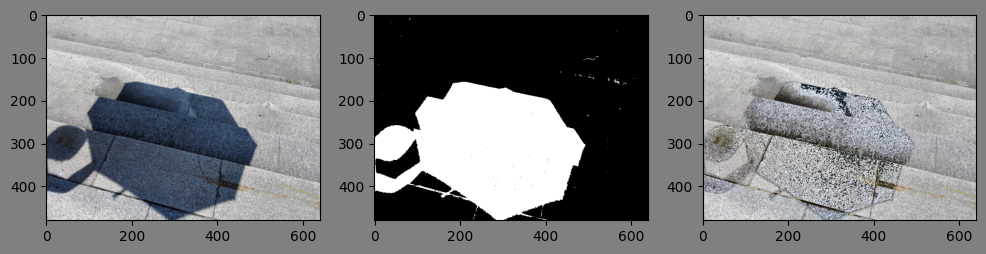

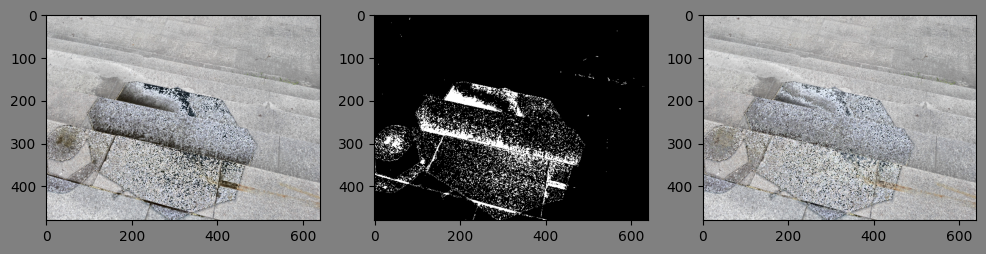

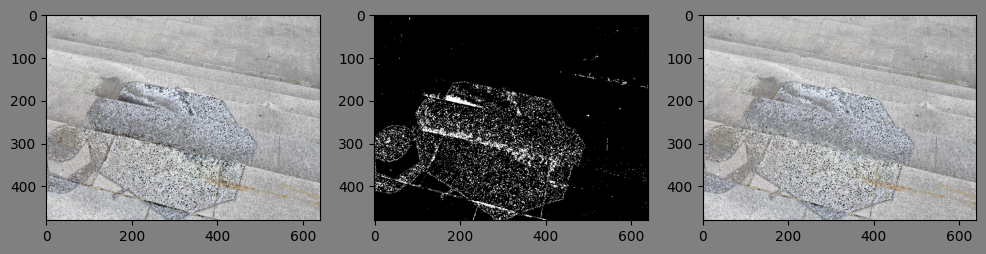

In [87]:
shadow_remover = ShadowRemover(itr=3,method='rgb_lab_hsv',ab_threshold=-255,lab_adjustment=True,
                               region_adjustment_kernel_size=30,shadow_dilation_kernel_size=7,shadow_dilation_iteration=7,
                               shadow_size_threshold=20,
                               verbose=False,plot_results=True)

shadow_remover.set_image("Images/image4.png",use_blurring=False)
original_image_list, mask_list, removed_shadow_image_list = shadow_remover.remove_shadows()

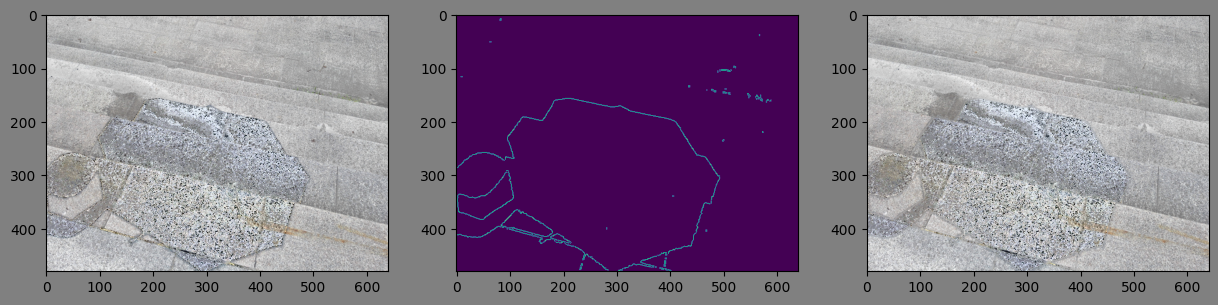

In [88]:
refined_image = shadow_remover.refine_image_edges(15)

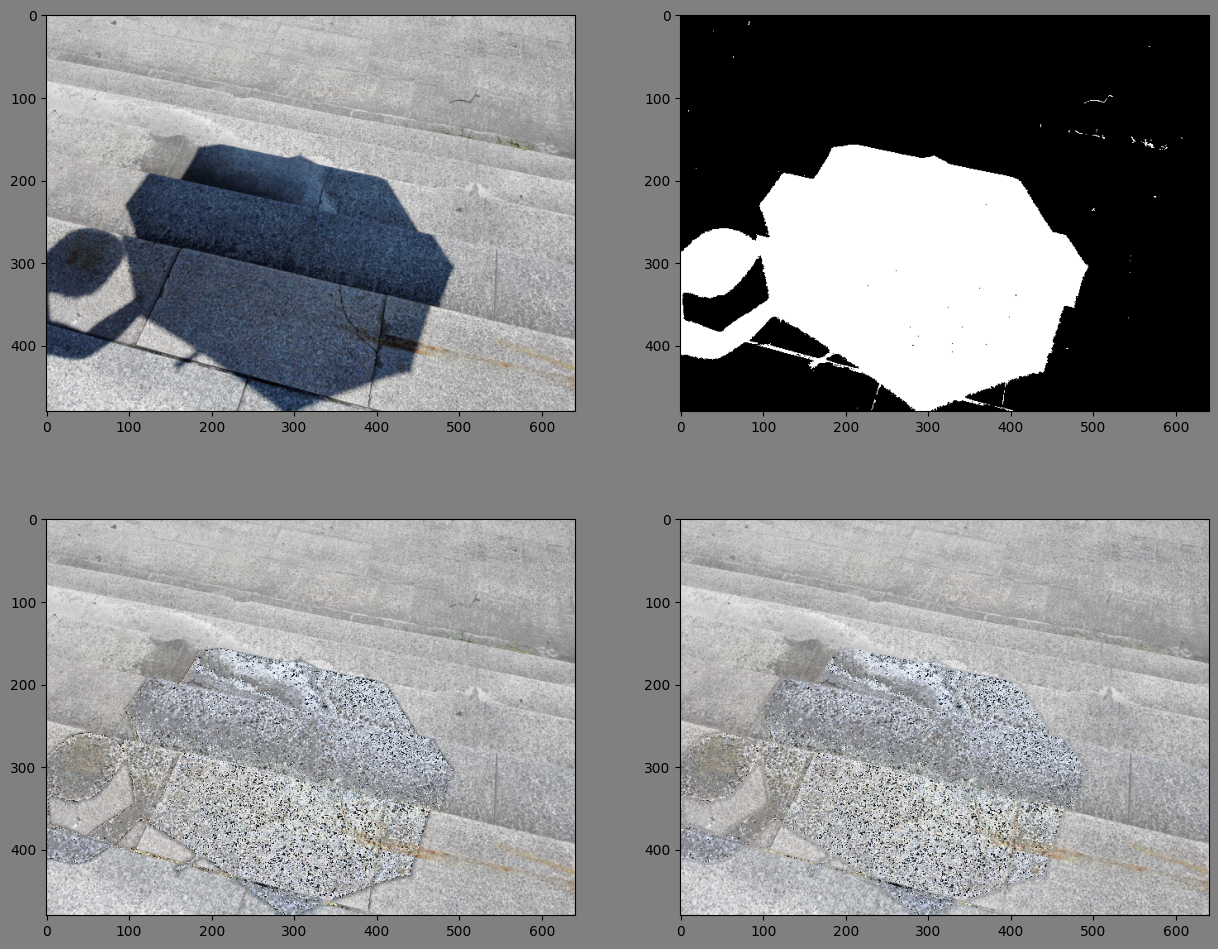

In [89]:
plt.figure(figsize=(15 , 12),facecolor='gray')
plt.subplot(2,2,1)
plt.imshow(original_image_list[0])
plt.subplot(2,2,2)
plt.imshow(mask_list[0])
plt.subplot(2,2,3)
plt.imshow(removed_shadow_image_list[-1])
plt.subplot(2,2,4)
plt.imshow(refined_image)